# Stochastic processes tests
M. Lamoureux
March 2, 2016

I want to try out some code that generates some random processes, and then try to extract some parameters from that code.



Let's start with some simple Brownian motion. Let's assume we build a path with initial value $W(0) = W_0$, and variable that is scalable, so the increment $W(t)-W(s)$ has variace $V_0\cdot(t-s)$. The question is, given a bunch of these paths, can we estimate the parameters $W_0$ and $V_0$.

We have a pretty good idea that just looking at the $W(T)$, taking their averages should give us $W_0$, and taking their variance should give us $V_0$. Let's see if that is true. 



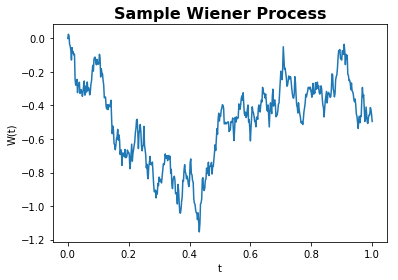

In [1]:
## Here is some simple code just to show how to get a brownian motion path.
## From the book Python for Scientists by John Stewart.

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr

W0 = 0  # the initial point of the path
V0 = 1  # the variance scale
T=1   # time interval of one second
N = 500  # number of steps in the interval
t,dt=np.linspace(0,T,N+1,retstep=True)
dW=npr.normal(0.0,np.sqrt(V0*dt),N+1)   # the delta W in the Brownian motion
dW[0]=W0   # set initial position to W0
W=np.cumsum(dW)   # integrate the dW

plt.ion()  # interactive plot mode

plt.plot(t,W)
plt.xlabel('t')
plt.ylabel('W(t)')
plt.title('Sample Wiener Process',weight='bold',size=16)

Let's rewrite this as a function that we can call many times, and run statistics on the results. 


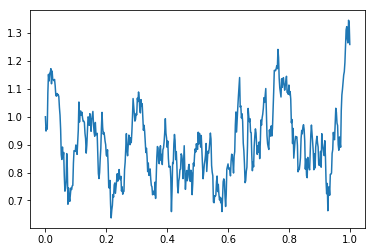

In [2]:
def weiner(W0,V0,T,N):
    t,dt=np.linspace(0,T,N+1,retstep=True)
    dW=npr.normal(0.0,np.sqrt(V0*dt),N+1)   # the delta W in the Brownian motion
    dW[0]=W0   # set initial position to W0
    W=np.cumsum(dW)   # integrate the dW
    return t,W

t,W = weiner(1,1,1,500)
plt.plot(t,W)

    

In [3]:
np.size(W)

501

In [4]:
W[500]

1.2592800464050586

In [5]:
np.average(W)

0.90632767241835144

In [6]:
# So, let's run a bunch of trials of the brownian motion.
# We will only look at the last value in the path
# The average of these should be W0
# The variance of these should be V0*T

W0=1.234
V0=.37
T=2
nsteps = 500

ntrials=10000
results = np.zeros(ntrials)

for k in range(ntrials):
    t,w = weiner(W0,V0,T,nsteps)
    results[k]=w[-1]
   
np.average(results),np.var(results)/T
    



(1.2242915398250265, 0.37257376659950159)

Hey, that looked pretty good with 10,000 sample runs.

Let's try something from Ito's calculus. Start with $X$ as a Wiener process $W$ with, say $X(0) = 0$, and define a new process $Y(t) = \exp(-X(t)/2).$ From Ito calculus, this new process is of the form
$$ dY = -\frac{1}{2}Y \, dW + \frac{1}{8} Y \, dt\qquad \mbox{with } Y(0) = 1.$$
The first term $-1/2 Y$ comes from the derivative of the exponential. The second term is from the second derivative -- this is something new and that's what made Ito famous.  

Taking expected values, 
$$ d \langle Y \rangle = \frac{1}{8} \langle Y \rangle \, dt$$ 
so we expect an exponential solution $\langle Y \rangle = e^{t/8}$. 

Notice if we didn't have that second term, then we would not have obtained an exponential here. So we would expect a flat line path, on average. So we should really see something interesting in the numerics.

So, let's create a bunch of paths for $Y$, take their mean, and compare it with the exponential.


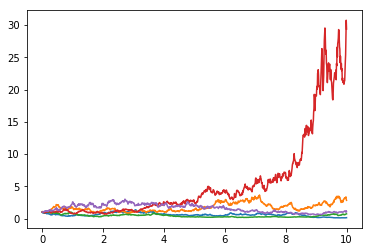

In [7]:
# set some parameters for the Weiner process
W0=0
V0=1
T=10
nsteps = 1000
ntrials = 5000
t,dt = np.linspace(0,T,nsteps+1,retstep=True)
dW = npr.normal(0.0,np.sqrt(V0*dt),(ntrials,nsteps+1)) # this is a 2D array of normal values
dW[:,0]=W0
W=np.cumsum(dW,axis=1)  # these are the Brownian motion paths
Y=np.exp(-0.5*W)  # now we take their exponentials, with the coefficient 1/2

Ymean = np.mean(Y,axis=0)  # this is the average of all our paths
Yexact = np.exp(t/8)

# We plot a few curves
plt.plot(t,Y[0,:],t,Y[1,:],t,Y[2,:],t,Y[3,:],t,Y[4,:])

Look at the large range of values, going from 0.6 up to 2.0. When we average, we get a much tighter range of values for the average path. But still with an increasing trend.

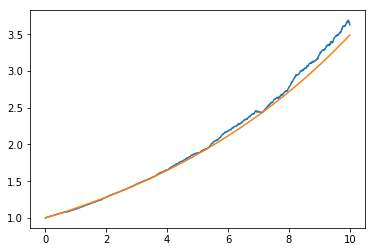

In [8]:
plt.plot(t,Ymean,t,Yexact)

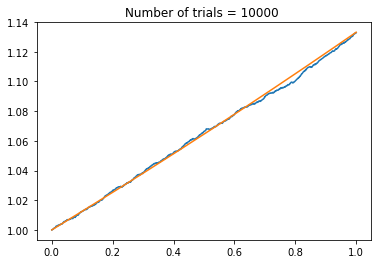

In [9]:
## Oh heck, let's get everything just the way I want it

# set some parameters for the Weiner process
W0=0
V0=1
T=1
nsteps = 1000
ntrials = 10000
t,dt = np.linspace(0,T,nsteps+1,retstep=True)
dW = npr.normal(0.0,np.sqrt(V0*dt),(ntrials,nsteps+1)) # this is a 2D array of normal values
dW[:,0]=W0
W=np.cumsum(dW,axis=1)  # these are the Brownian motion paths
Y=np.exp(-0.5*W)  # now we take their exponentials, with the coefficient 1/2

Ymean = np.mean(Y,axis=0)  # this is the average of all our paths
Yexact = np.exp(t/8)

# we plot
plt.plot(t,Ymean,t,Yexact)
plt.title("Number of trials = %d " % ntrials)

So this suggests a method for picking parameters in the model $Y=Y(0)\exp(-aX)$.
Taking averages of the initial values in the sample paths will give an estimate of $Y(0)$. Taking averages of the final values will be an estimate of $Y(0)\exp(a^2 T/2).$ So, taking logs and dividing by $T$, you can estimate $a^2$ directly.

On the other hand, maybe it makes sense to do a least square fit of an exponential curve to the average path. That is another idea for computing the parameters $Y(0)$ and $a$ in the model. If I were doing this project, I would try both, and see what works. 

## More general models

With $W$ a Weiner process, we can look at models with $$dX = aX \, dt + b X \, dW,$$
with $a$ and $b$ some fixed parameters. With $Y(t) = f(X(t))$, the Ito calculus predicts the process satisfies
$$dY = b f'(X) \, dW + \left( af'(X) + \frac{1}{2} b^2 f''(X) \right) dt.$$
So for a given function $f$ (like an exponential), we get a process where the parameters $a,b$ show up explicitly. So we should be able to estimate these from our average paths. 

Before introducing jumps to the model, maybe one should try estimating parameters in this slightly more general model.